# Machine Learning Engineer Nanodegree
## Project 5: Deep Learning Capstone - Number Recognition for SVHN



Import libriaries and dependencies.

In [1]:
%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io as io
import numpy as np
import csv

import os
from datetime import datetime

Load data.

In [2]:
train_data = io.loadmat("../data/train_32x32.mat")
test_data = io.loadmat("../data/test_32x32.mat")

train_dataset = train_data['X']
train_labels = train_data['y']
test_dataset = test_data['X']
test_labels = test_data['y']

print('Training set', train_dataset.shape, train_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)    

Training set (32, 32, 3, 73257) (73257, 1)
Test set (32, 32, 3, 26032) (26032, 1)


Reformat data to fit Tensorflow API.

In [3]:
IMAGE_SIZE = 32
NUM_CLASSES = 10
NUM_CHANNELS = 1
NUM_TRAIN_DATA = 70000

def reformat(dataset, labels):
    dataset = np.transpose(dataset, (3, 0, 1, 2)).astype(np.float32)
    one_hot_labels = []
    for label in labels:
        one_hot_label = np.zeros(NUM_CLASSES, np.float32)
        if label[0] == 10:
            one_hot_label[0] = 1.0
        else:
            one_hot_label[label[0]] = 1.0
        one_hot_labels.append(one_hot_label)
    labels = np.array(one_hot_labels).astype(np.float32)
    return dataset, labels

valid_dataset = train_dataset[:, :, :, NUM_TRAIN_DATA : ]
valid_labels = train_labels[NUM_TRAIN_DATA : ]
train_dataset = train_dataset[:, :, :, : NUM_TRAIN_DATA]
train_labels = train_labels[ : NUM_TRAIN_DATA]

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (70000, 32, 32, 3) (70000, 10)
Validation set (3257, 32, 32, 3) (3257, 10)
Test set (26032, 32, 32, 3) (26032, 10)


Show original images.

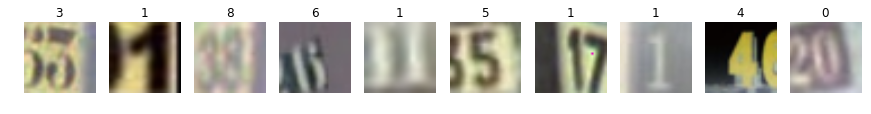

In [4]:
plt.rcParams['figure.figsize'] = (15.0, 15.0)
f, ax = plt.subplots(nrows=1, ncols=10)

for i, j in enumerate(np.random.randint(0, train_labels.shape[0], size=10)):
    ax[i].axis('off')
    ax[i].set_title(np.argmax(train_labels[j]), loc='center')
    ax[i].imshow(train_dataset[j])

Input normalization.

In [5]:
def normalize(dataset):
    new_dataset = np.add.reduce(dataset, keepdims=True, axis=3)
    new_dataset = new_dataset / 3.0
    return new_dataset / 128.0 - 1.0

new_train_dataset = normalize(train_dataset)
new_valid_dataset = normalize(valid_dataset)
new_test_dataset = normalize(test_dataset)

print('Training set', new_train_dataset.shape, train_labels.shape)
print('Validation set', new_valid_dataset.shape, valid_labels.shape)
print('Test set', new_test_dataset.shape, test_labels.shape)

Training set (70000, 32, 32, 1) (70000, 10)
Validation set (3257, 32, 32, 1) (3257, 10)
Test set (26032, 32, 32, 1) (26032, 10)


Show normalized images.

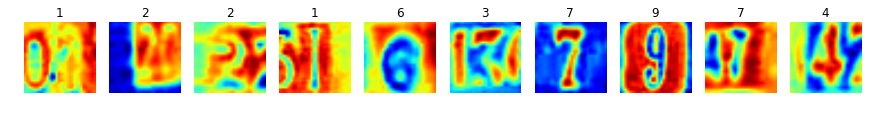

In [6]:
f, ax = plt.subplots(nrows=1, ncols=10)
for i, j in enumerate(np.random.randint(0, train_labels.shape[0], size=10)):
    ax[i].axis('off')
    ax[i].set_title(np.argmax(train_labels[j]), loc='center')
    ax[i].imshow(new_train_dataset[j].squeeze())

In [7]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Define hyper-parameters.

In [21]:
batch_size = 128
conv1_depth = 16
conv2_depth = 32
conv3_depth = 64
hidden_layer1_size = 64
hidden_layer2_size = 16
patch_size = 5
start_learning_rate = 0.001
regularization_lambda = 0.0005
dropout_rate = 0.9
learning_rate_decay_rate = 0.99

Define graph and model.

In [22]:
graph = tf.Graph()
with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))
    tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, NUM_CLASSES))
    tf_valid_dataset = tf.constant(new_valid_dataset)
    tf_test_dataset = tf.constant(new_test_dataset)

    conv1_filter = tf.Variable(tf.truncated_normal([patch_size, patch_size, NUM_CHANNELS, conv1_depth], stddev = 0.1))
    conv1_biases = tf.Variable(tf.zeros([conv1_depth]))

    conv2_filter = tf.Variable(tf.truncated_normal([patch_size, patch_size, conv1_depth, conv2_depth], stddev = 0.1))
    conv2_biases = tf.Variable(tf.constant(1.0, shape = [conv2_depth]))

    conv3_filter = tf.Variable(tf.truncated_normal([patch_size, patch_size, conv2_depth, conv3_depth], stddev = 0.1))
    conv3_biases = tf.Variable(tf.constant(1.0, shape = [conv3_depth]))
    
    layer4_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, conv3_depth, hidden_layer1_size], stddev = 0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape = [hidden_layer1_size]))
    
    layer5_weights = tf.Variable(tf.truncated_normal([hidden_layer1_size, hidden_layer2_size], stddev = 0.1))
    layer5_biases = tf.Variable(tf.constant(1.0, shape = [hidden_layer2_size]))
    
    layer6_weights = tf.Variable(tf.truncated_normal([hidden_layer2_size, NUM_CLASSES], stddev = 0.1))
    layer6_biases = tf.Variable(tf.constant(1.0, shape = [NUM_CLASSES]))

    def model(dataset, train = False):
        conv = tf.nn.conv2d(dataset, conv1_filter, [1, 1, 1, 1], padding = 'VALID')
        hidden = tf.nn.relu(conv + conv1_biases)
        hidden = tf.nn.local_response_normalization(hidden)
        hidden = tf.nn.max_pool(hidden, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')

        conv = tf.nn.conv2d(hidden, conv2_filter, [1, 1, 1, 1], padding = 'VALID')
        hidden = tf.nn.relu(conv + conv2_biases)
        hidden = tf.nn.local_response_normalization(hidden)
        hidden = tf.nn.max_pool(hidden, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
    
        conv = tf.nn.conv2d(hidden, conv3_filter, [1, 1, 1, 1], padding = 'SAME')
        hidden = tf.nn.relu(conv + conv3_biases)
        
        conv = tf.nn.conv2d(hidden, layer4_weights, [1, 1, 1, 1], padding = 'VALID')
        hidden = tf.nn.relu(conv + layer4_biases)
        
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer5_weights) + layer5_biases)
        
        if train:
            hidden = tf.nn.dropout(hidden, dropout_rate)

        return tf.matmul(hidden, layer6_weights) + layer6_biases

    logits = model(tf_train_dataset, True)

    regularization = regularization_lambda * \
        (tf.nn.l2_loss(layer4_weights) + tf.nn.l2_loss(layer4_biases)
        + tf.nn.l2_loss(layer5_weights) + tf.nn.l2_loss(layer5_biases)
        + tf.nn.l2_loss(layer6_weights) + tf.nn.l2_loss(layer6_biases))
    
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) \
        + regularization

    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(start_learning_rate, 
                                                global_step * batch_size, 
                                                100, 
                                                learning_rate_decay_rate,
                                                staircase = True)
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))
    
    saver = tf.train.Saver()

Training begins!

In [ ]:
NUM_STEPS = 10001

start_time = None
end_time = None
prev_time = None
cur_time = None

with tf.Session(graph = graph) as session:
    tf.initialize_all_variables().run()
    with open('../model/stats_2.csv', 'w') as statsfile:
        statswriter = csv.writer(statsfile, delimiter = ',')
        
        start_time = datetime.now()
        statswriter.writerow([start_time])
        
        prev_time = datetime.now()
        for step in range(NUM_STEPS):
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            batch_dataset = new_train_dataset[offset : (offset + batch_size), :, :, :]
            batch_labels = train_labels[offset : (offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_dataset, tf_train_labels : batch_labels}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict = feed_dict)
            if (step % 50 == 0):
                cur_time = datetime.now()
                print('time cost: ', cur_time - prev_time)
                prev_time = cur_time

                batch_accuracy = accuracy(predictions, batch_labels)
                valid_accuracy = accuracy(valid_prediction.eval(), valid_labels)
                
                if (step % 500 == 0):
                    print('Minibatch loss at step %d: %f' % (step, l))
                    print('Minibatch accuracy: %.1f%%' % (batch_accuracy))
                    print('Validation accuracy: %.1f%%' % (valid_accuracy))
                
                statswriter.writerow([cur_time - prev_time, step, batch_accuracy, valid_accuracy])
        
        test_accuracy = accuracy(test_prediction.eval(), test_labels)
        print('Test accuracy: %.1f%%' % (test_accuracy))
        statswriter.writerow(['test_accuracy', test_accuracy])
        
        end_time = datetime.now()
        print('Total time cost: ', end_time - start_time)
        statswriter.writerow(['time cost: ', end_time - start_time])
        
        save_path = saver.save(session, "../model/CNN_2.ckpt")
        print("Model saved in file: %s" % save_path)

time cost:  0:00:00.423929
Minibatch loss at step 0: 3.138674
Minibatch accuracy: 7.0%
Validation accuracy: 9.9%
